# Korean Studies EDA

In [1]:
import pandas as pd
import requests
from tqdm.auto import tqdm
tqdm.pandas()
import json
import glob
import time
import re
from natsort import natsorted
import itertools
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
import os
import concurrent.futures
import math

### 한국학 저널

In [2]:
df_oa = pd.read_pickle('./240402_KS_works.pkl')

In [3]:
df_kci = pd.read_pickle('./240407_KS_KCI_merged_tokens.pkl')

In [4]:
df = df_kci.merge(df_oa[['id','primary_topic','topics','authorships','cited_by_count']],how='left')

In [5]:
# 초록 없는 행 제외
# df = df.dropna(subset=['abstract']).reset_index(drop=True)
# len(df)

In [214]:
df

,id,doi,journal,origin,title,publication_year,abstract,oa_kci,cited_by_count,title_tokens,...,primary_topic,topics,authorships,primary_topic_name,topics_name,subfield_name,field_name,domain_name,authorships_id,country_code
0,https://openalex.org/W4384432764,https://doi.org/10.1353/seo.2023.a902140,Seoul Journal of Korean Studies,in,Felled Forests and Fallowed Fields: Establishi...,2023,Goryeo (918–1392) was a politically and commer...,oa,1,"[fell, forest, fallowe, field, establish, narr...",...,"{'id': 'https://openalex.org/T12890', 'display...","[{'id': 'https://openalex.org/T12890', 'displa...","[{'author_position': 'first', 'author': {'id':...",Silk Roads and Eurasian Exchange Networks,"[Silk Roads and Eurasian Exchange Networks, Re...","[Anthropology, Sociology and Political Science...","[Social Sciences, Social Sciences, Social Scie...","[Social Sciences, Social Sciences, Social Scie...",[https://openalex.org/A5023897005],[CA]
1,https://openalex.org/W4384432829,https://doi.org/10.1353/seo.2023.a902142,Seoul Journal of Korean Studies,in,The History of the Formation of Silhak in Mode...,2023,This article examines the historical trajector...,oa,1,"[history, formation, silhak, modern, korea, pr...",...,"{'id': 'https://openalex.org/T10893', 'display...","[{'id': 'https://openalex.org/T10893', 'displa...","[{'author_position': 'first', 'author': {'id':...",Religious Diversity and Regulation in Chinese ...,[Religious Diversity and Regulation in Chinese...,"[Sociology and Political Science, Cultural Stu...","[Social Sciences, Social Sciences, Social Scie...","[Social Sciences, Social Sciences, Social Scie...",[https://openalex.org/A5091242804],[]
2,https://openalex.org/W1578642520,https://doi.org/10.1353/seo.2015.0003,Seoul Journal of Korean Studies,in,Diplomatic War: Inter-Korean Relations in the ...,2015,The period of the 1970s was a turning point in...,oa,5,"[diplomatic, war, inter, -, korean, relation, ...",...,"{'id': 'https://openalex.org/T13135', 'display...","[{'id': 'https://openalex.org/T13135', 'displa...","[{'author_position': 'first', 'author': {'id':...",Global Social Movements of the 1960s and 1970s,[Global Social Movements of the 1960s and 1970...,"[Sociology and Political Science, History, Soc...","[Social Sciences, Arts and Humanities, Social ...","[Social Sciences, Social Sciences, Social Scie...",[https://openalex.org/A5033947212],[US]
3,https://openalex.org/W1590043962,https://doi.org/10.1353/seo.2013.0023,Seoul Journal of Korean Studies,in,More Valuable than Gold: Korean Tungsten and t...,2013,A central component of the Japanese government...,oa,5,"[valuable, gold, korean, tungsten, japanese, w...",...,"{'id': 'https://openalex.org/T11198', 'display...","[{'id': 'https://openalex.org/T11198', 'displa...","[{'author_position': 'first', 'author': {'id':...",Cultural Dynamics in Japan and East Asia,[Cultural Dynamics in Japan and East Asia],[Cultural Studies],[Social Sciences],[Social Sciences],[https://openalex.org/A5080221000],[US]
4,https://openalex.org/W210363985,https://doi.org/10.1353/seo.2014.0005,Seoul Journal of Korean Studies,in,Parhae in Historiography and Archaeology: Inte...,2014,The history of the kingdom of Parhae (Ch. Boha...,oa,5,"[parhae, historiography, archaeology, internat...",...,"{'id': 'https://openalex.org/T13337', 'display...","[{'id': 'https://openalex.org/T13337', 'displa...","[{'author_position': 'first', 'author': {'id':...",Socio-Political Dynamics of North Korea,"[Socio-Political Dynamics of North Korea, Conf...","[Sociology and Political Science, Political Sc...","[Social Sciences, Social Sciences, Social Scie...","[Social Sciences, Social Sciences, Social Scie...",[https://openalex.org/A5054085479],[KR]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,ART002721077,https://doi.org/10.25024/review.2021.24.1.009,The Review of Korean Studies,in,The Haunted Maiden Deities on Jeju Island,2021,Jeju Island reveals exemplary openness to ghos.

##### 토픽

In [6]:
df['primary_topic_name'] = df['primary_topic'].dropna().map(lambda x:x['display_name'])
df['topics_name'] = df['topics'].dropna().progress_map(lambda x:[t['display_name'] for t in x])
df['subfield_name'] = df['topics'].dropna().progress_map(lambda x:[t['subfield']['display_name'] for t in x])
df['field_name'] = df['topics'].dropna().progress_map(lambda x:[t['field']['display_name'] for t in x])
df['domain_name'] = df['topics'].dropna().progress_map(lambda x:[t['domain']['display_name'] for t in x])

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

In [7]:
# Calculate the frequency of each primary_topic_name across all origins
topic_freq = df.groupby('primary_topic_name').size().sort_values(ascending=False)

# # Select the top 5 primary_topic_names
top5_topics = topic_freq.head(5)
topic_freq

primary_topic_name
Global Impact of Korean Popular Culture                          579
Cultural Dynamics in Japan and East Asia                         450
Religious Diversity and Regulation in Chinese Society            351
Socio-Political Dynamics of North Korea                          338
Immigrant Entrepreneurship in Advanced Economies                  46
                                                                ... 
Leisure Activities and Subjective Well-Being Relationship          1
Lexicography and Dictionary Development                            1
Liberal Political Thought in 19th Century Europe                   1
Life Writing and Correspondence Studies                            1
Importance of Marine Spatial Planning in Ecosystem Management      1
Length: 254, dtype: int64

In [8]:
top4_topics = top5_topics.index[:4].tolist()
top4_topics

['Global Impact of Korean Popular Culture',
 'Cultural Dynamics in Japan and East Asia',
 'Religious Diversity and Regulation in Chinese Society',
 'Socio-Political Dynamics of North Korea']

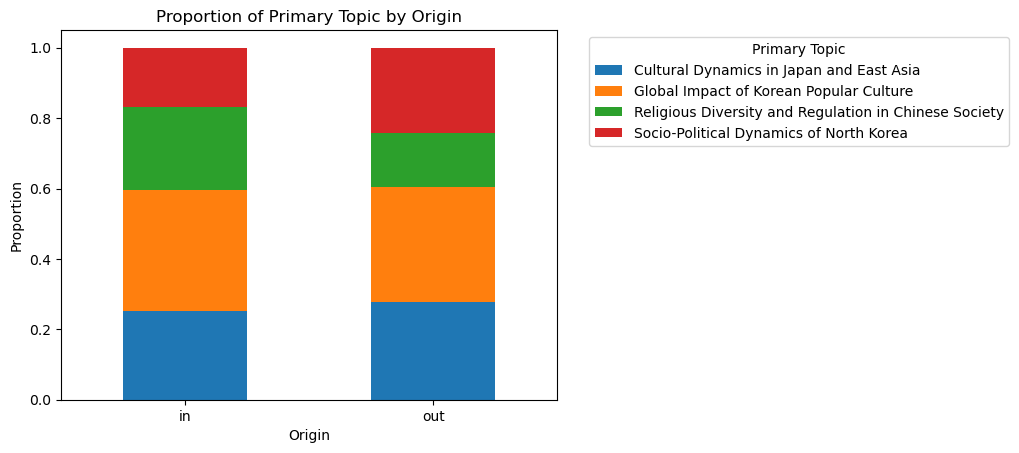

In [9]:
# Filter the dataframe based on the top3_topics
filtered_df = df[df['primary_topic_name'].isin(top4_topics)]

# Group the filtered dataframe by origin and primary_topic_name and calculate the count
grouped_df = filtered_df.groupby(['origin', 'primary_topic_name']).size().unstack()

# Calculate the proportion of each primary_topic_name for each origin
proportion_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

# Plot the bar plot
ax = proportion_df.plot(kind='bar', stacked=True)
plt.xlabel('Origin')
plt.ylabel('Proportion')
plt.title('Proportion of Primary Topic by Origin')

# Rotate x-axis labels
plt.xticks(rotation=0)

# Move the legend outside of the plot
ax.legend(title='Primary Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [10]:
grouped_df

primary_topic_name,Cultural Dynamics in Japan and East Asia,Global Impact of Korean Popular Culture,Religious Diversity and Regulation in Chinese Society,Socio-Political Dynamics of North Korea
origin,,,,
in,265,362,248,177
out,185,217,103,161


In [11]:
proportion_df

primary_topic_name,Cultural Dynamics in Japan and East Asia,Global Impact of Korean Popular Culture,Religious Diversity and Regulation in Chinese Society,Socio-Political Dynamics of North Korea
origin,,,,
in,0.251901,0.344106,0.235741,0.168251
out,0.277778,0.325826,0.154655,0.241742


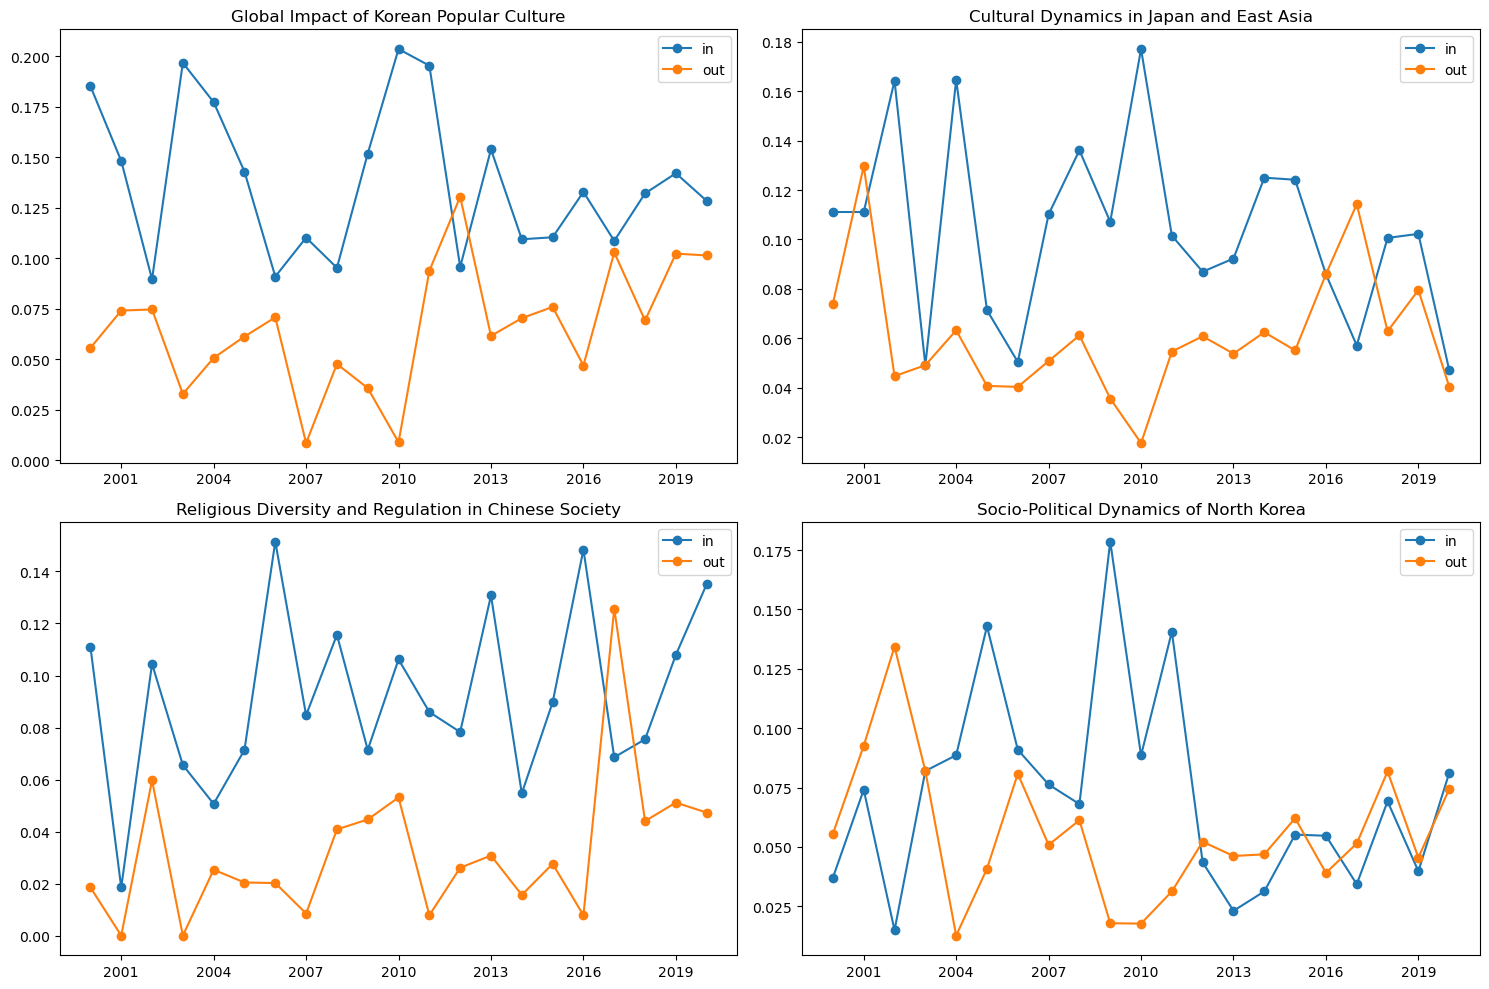

In [12]:
import matplotlib.ticker as ticker

topics = ['Global Impact of Korean Popular Culture',
          'Cultural Dynamics in Japan and East Asia',
          'Religious Diversity and Regulation in Chinese Society',
          'Socio-Political Dynamics of North Korea']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Calculate total counts per year for the specified range
total_counts_per_year = df[(df['publication_year'] >= 2000) & (df['publication_year'] <= 2020)].groupby('publication_year').size()

# Create an index of all years within the specified range
all_years = pd.Index(range(2000, 2021))

for i, topic in enumerate(topics):
    for origin in ['in', 'out']:
        # Filter by 'primary_topic_name', 'origin', and 'publication_year'
        data = df[(df['primary_topic_name'] == topic) & (df['origin'] == origin) & (df['publication_year'] >= 2000) & (df['publication_year'] <= 2020)]
        data_grouped = data.groupby('publication_year').size()

        # Reindex with all_years filling missing years with 0
        data_grouped = data_grouped.reindex(all_years, fill_value=0)

        # Calculate proportion
        proportion = data_grouped / total_counts_per_year

        # Plot
        ax = axs[i//2, i%2]
        ax.plot(proportion.index, proportion, marker='o', linestyle='-', label=f'{origin}')
        ax.set_title(topic)
        ax.legend()

        # Set x-axis to only use integer values
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [13]:
# top4 topic 선택
top4_topics = ['Cultural Dynamics in Japan and East Asia', 'Global Impact of Korean Popular Culture',
               'Religious Diversity and Regulation in Chinese Society', 'Socio-Political Dynamics of North Korea']

# top4 topic에 해당하는 행만 필터링
filtered_df = df[df['primary_topic_name'].isin(top4_topics)]

# primary_topic_name을 기준으로 그룹화하여 피인용횟수의 합과 topic 개수 계산
grouped_df = filtered_df.groupby('primary_topic_name').agg({'cited_by_count': 'sum', 'primary_topic_name': 'count'})

# 피인용횟수 대비 topic 개수 계산
grouped_df['cited_by_count_per_topic'] = grouped_df['cited_by_count'] / grouped_df['primary_topic_name']

# 결과 출력
print(grouped_df)


                                                   cited_by_count  \
primary_topic_name                                                  
Cultural Dynamics in Japan and East Asia                      626   
Global Impact of Korean Popular Culture                       964   
Religious Diversity and Regulation in Chinese S...            470   
Socio-Political Dynamics of North Korea                       530   

                                                    primary_topic_name  \
primary_topic_name                                                       
Cultural Dynamics in Japan and East Asia                           450   
Global Impact of Korean Popular Culture                            579   
Religious Diversity and Regulation in Chinese S...                 351   
Socio-Political Dynamics of North Korea                            338   

                                                   cited_by_count_per_topic  
primary_topic_name                                            

In [14]:
grouped_df

,cited_by_count,primary_topic_name,cited_by_count_per_topic
primary_topic_name,,,
Cultural Dynamics in Japan and East Asia,626,450,1.391111
Global Impact of Korean Popular Culture,964,579,1.66494
Religious Diversity and Regulation in Chinese Society,470,351,1.339031
Socio-Political Dynamics of North Korea,530,338,1.568047


##### 저자 소속 국가

In [15]:
df.loc[~pd.isna(df['authorships']),'authorships']

0       [{'author_position': 'first', 'author': {'id':...
1       [{'author_position': 'first', 'author': {'id':...
2       [{'author_position': 'first', 'author': {'id':...
3       [{'author_position': 'first', 'author': {'id':...
4       [{'author_position': 'first', 'author': {'id':...
                              ...                        
2726    [{'author_position': 'first', 'author': {'id':...
2727    [{'author_position': 'first', 'author': {'id':...
2728                                                   []
2729    [{'author_position': 'first', 'author': {'id':...
2730                                                   []
Name: authorships, Length: 2731, dtype: object

In [16]:
df['authorships_id'] = df.loc[~pd.isna(df['authorships']),'authorships'].progress_map(lambda x:[a['author']['id'] for a in x])

  0%|          | 0/2731 [00:00<?, ?it/s]

In [17]:
authorship_id = df['authorships_id'].dropna().tolist()
authorship_id = list(set(list(itertools.chain(*authorship_id))))

In [75]:
author_file_list = glob.glob('./data/author/*.json') + glob.glob('./data/author_cited/*.json')
len(author_file_list)

5229

In [19]:
# openalex_author_json = []
# for file in tqdm(author_file_list):
#     with open(file,'r') as f:
#         temp_json = json.load(f)
#     openalex_author_json.append(temp_json)

In [76]:
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

with concurrent.futures.ThreadPoolExecutor() as executor:
    openalex_author_json = list(tqdm(executor.map(load_json, author_file_list), total=len(author_file_list)))

  0%|          | 0/5229 [00:00<?, ?it/s]

In [86]:
df_author = pd.DataFrame(openalex_author_json)
df_author = df_author.dropna(subset='last_known_institutions').reset_index(drop=True).reset_index(drop=True)

In [87]:
df_author['country_code'] = df_author.loc[df_author['last_known_institutions'].str.len()!=0,'last_known_institutions'].progress_map(lambda x:x[0]['country_code'])

  0%|          | 0/3864 [00:00<?, ?it/s]

In [ ]:
# df_author['country_code'].value_counts()

In [88]:
# 최신 저자 소속 국가 없는 경우
pd.isna(df_author['country_code']).sum()

1361

In [89]:
author_country = df_author[['id','country_code']].to_dict(orient='records')
author_country = [d for d in author_country if d['country_code'] == d['country_code']]

In [90]:
# authorships_id 열의 각 요소에 대해 country_code 매칭
def get_country_codes(author_ids):
    country_codes = []
    for author_id in author_ids:
        country_code = next((d['country_code'] for d in author_country if d['id'] == author_id), None)
        country_codes.append(country_code)
    return country_codes

In [217]:
import numpy as np
# 'authorships_id' 열에서 NaN과 None 값을 제외한 요소 추출
authorships_ids = df['authorships_id'].dropna().values
authorships_ids = [id for id in authorships_ids if id is not None]

# 요소의 총 개수 계산
total_count = len(authorships_ids)

print("Total Count:", total_count)


Total Count: 2731


In [ ]:
df['country_code'] = df['authorships_id'].dropna().apply(get_country_codes)
df['country_code'] = df['country_code'].dropna().apply(lambda lst: [x for x in lst if x is not None])

In [220]:
df['country_code'].str.len().sum()

1875.0

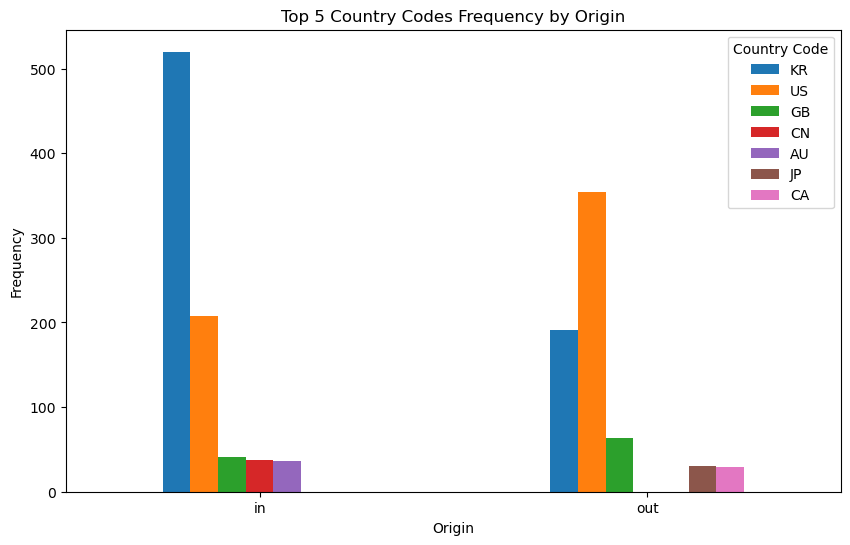

In [93]:
# country_code 리스트를 행으로 확장
df_exploded = df.explode('country_code')

# origin 및 country_code 별로 그룹화하여 출현 횟수 계산
count_per_origin_country = df_exploded.groupby(['origin', 'country_code']).size().reset_index(name='count')

# 빈 country_code 제거
df_exploded = df_exploded[df_exploded['country_code'].notna()]

# origin 별, country_code 별 출현 횟수 계산 및 상위 5개 선택
top_5_countries_by_origin = df_exploded.groupby('origin')['country_code'].value_counts().groupby(level=0).head(5).unstack(fill_value=0)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 origin 유형별로 상위 5개 country_code의 빈도를 막대 그래프로 시각화
top_5_countries_by_origin.plot(kind='bar', ax=ax)

# 축 이름 및 타이틀 설정
ax.set_xlabel('Origin')
ax.set_ylabel('Frequency')
ax.set_title('Top 5 Country Codes Frequency by Origin')

# 범례 설정
ax.legend(title='Country Code')

# 그래프 표시
plt.xticks(rotation=0)  # x축 라벨 회전 설정
plt.show()

In [94]:
top_5_countries_by_origin

country_code,KR,US,GB,CN,AU,JP,CA
origin,,,,,,,
in,520,208,41,37,36,0,0
out,191,354,63,0,0,30,29


In [95]:
df_exploded.groupby('origin')['country_code'].value_counts().groupby(level=0).head(5)

origin  country_code
in      KR              520
        US              208
        GB               41
        CN               37
        AU               36
out     US              354
        KR              191
        GB               63
        JP               30
        CA               29
Name: count, dtype: int64

### 한국학 저널을 인용한 저널

In [31]:
cited_file_list = glob.glob('./data/cited/*.json')
len(cited_file_list)

3379

In [122]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        temp_json = json.load(file)
    # 리스트가 비어 있지 않은지 확인
    if temp_json:
        for d in temp_json:
            d['cites'] = Path(file_path).stem
        # print("Updated list:", temp_json)
    return temp_json
    
# 결과를 저장할 리스트 초기화
openalex_cited_json = []

with ThreadPoolExecutor() as executor:
    # tqdm으로 진행 상황 표시
    for result in tqdm(executor.map(load_json, cited_file_list), total=len(cited_file_list)):
        openalex_cited_json.extend(result)

  0%|          | 0/3379 [00:00<?, ?it/s]

In [123]:
df_cited = pd.DataFrame(openalex_cited_json)
df_cited

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,cites,versions,fulltext_origin
0,https://openalex.org/W2071789989,https://doi.org/10.1353/jks.2013.0002,Racialization and Colonial Space: Intermarriag...,Racialization and Colonial Space: Intermarriag...,2013,2013-03-13,{'openalex': 'https://openalex.org/W2071789989...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W2525356293, https://ope...",https://api.openalex.org/works/W2071789989/ngrams,"{'Abstract': [0], 'This': [1, 118], 'article':...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 1}, {'year':...",2024-03-23T02:14:17.925251,2016-06-24,W1947383802,NaN,NaN
1,https://openalex.org/W1990283627,https://doi.org/10.1353/jks.2014.0001,Proletarian Sensibilities: The Body Politics o...,Proletarian Sensibilities: The Body Politics o...,2014,2014-03-14,{'openalex': 'https://openalex.org/W1990283627...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W2386088669, https://ope...",https://api.openalex.org/works/W1990283627/ngrams,"{'Abstract': [0], 'This': [1], 'article': [2],...",https://api.openalex.org/works?filter=cites:W1...,[],2024-03-24T11:05:25.755767,2016-06-24,W1947383802,NaN,NaN
2,https://openalex.org/W3014747407,https://doi.org/10.33526/ejks.20201902.171,"Modern Womanhood, the Ideology of the Housewif...","Modern Womanhood, the Ideology of the Housewif...",2020,2020-04-01,{'openalex': 'https://openalex.org/W3014747407...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W2325325677, https://ope...",https://api.openalex.org/works/W3014747407/ngrams,"{'This': [0], 'paper': [1], 'attempts': [2], '...",https://api.openalex.org/works?filter=cites:W3...,[],2024-03-06T12:04:45.071533,2020-04-10,W232845598,NaN,NaN
3,https://openalex.org/W2266837009,https://doi.org/10.1353/seo.2015.0025,A 350-Year History of a Chungin Family Line In...,A 350-Year History of a Chungin Family Line In...,2015,2015-01-01,{'openalex': 'https://openalex.org/W2266837009...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W312455760, https://open...",https://api.openalex.org/works/W2266837009/ngrams,"{'A': [0, 31, 173, 366], '350-Year': [1], 'His...",https://api.openalex.org/works?filter=cites:W2...,[],2024-03-23T01:07:31.430109,2016-06-24,W1490288492,NaN,NaN
4,https://openalex.org/W1865412357,None,The Filial Daughter of Kwaksan : Finger Severi...,The Filial Daughter of Kwaksan : Finger Severi...,2012,2012-12-01,{'openalex': 'https://openalex.org/W1865412357...,en,"{'is_oa': False, 'landing_page_url': 'http://w...",article,...,"[https://openalex.org/W146114063, https://open...",https://api.openalex.org/works/W1865412357/ngrams,"{'Among': [0], 'the': [1, 13, 17, 76, 79, 84, ...",https://api.openalex.org/works?filter=cites:W1...,[],2024-03-27T06:29:23.259717,2016-06-24,W2132065389,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6215,https://openalex.org/W2048433567,https://doi.org/10.3987/com-99-8699,Synthesis of Optically Active 2-Piperidylglycine,Synthesis of Optically Active 2-Piperidylglycine,1999,1999-01-01,{'openalex': 'https://openalex.org/W2048433567...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W2011275815, https://ope...",https://api.openalex.org/works/W2048433567/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2018, 'cited_by_count': 1}, {'year':...",2024-03-04T22:57:08.548779,2016-06-24,W2012802281,NaN,NaN
6216,https://openalex.org/W2343669200,https://doi.org/10.1080/10570314.2016.1163614,“The Only Dominator and Remaker of the World”:...,“The Only Dominator and Remaker of the World”:...,2016,2016-04-25,{'openalex': 'https://o

In [124]:
df_cited['cites'] = 'https://openalex.org/' + df_cited['cites']

In [125]:
# df에 있는 것만 필터
df_cited = df_cited[df_cited['cites'].isin(df['id'].tolist())].reset_index(drop=True)
len(df_cited)

4562

In [128]:
merged_df = pd.merge(df_cited, df[['id','origin']], left_on='cites', right_on='id', how='left')
# Assign 'origin' to df_cited
df_cited['origin'] = merged_df['origin']

In [130]:
df_cited['origin'].value_counts()

origin
in     2400
out    2162
Name: count, dtype: int64

In [134]:
df_cited_origin = df_cited.groupby('id').agg({'origin': lambda x: list(x)}).reset_index()

In [136]:
df_cited = df_cited.drop_duplicates(subset='id').reset_index(drop=True)

In [137]:
df_cited = df_cited.drop("origin", axis=1)

In [140]:
df_cited = df_cited.merge(df_cited_origin,how='left')

In [163]:
def determine_origin_type(origin_list):
    if 'in' in origin_list and 'out' in origin_list:
        return 'in_out'
    elif 'in' in origin_list:
        return 'only_in'
    elif 'out' in origin_list:
        return 'only_out'
    else:
        return 'none'

# Apply the function to the 'origin' column to create the 'origin_type' column
df_cited['origin_type'] = df_cited['origin'].apply(determine_origin_type)

In [167]:
df_cited['origin_type'].value_counts(normalize=True)

origin_type
only_in     0.468002
only_out    0.445275
in_out      0.086722
Name: proportion, dtype: float64

In [193]:
df_cited['origin']

0               [in]
1               [in]
2               [in]
3               [in]
4       [in, in, in]
            ...     
3339           [out]
3340           [out]
3341           [out]
3342           [out]
3343           [out]
Name: origin, Length: 3344, dtype: object

In [141]:
# def index_to_text(abstract_inverted_index):
#     abstract_index = {}
#     for k, vlist in abstract_inverted_index.items():
#         for v in vlist:
#             abstract_index[v] = k
#     abstract = ' '.join(abstract_index[k] for k in sorted(abstract_index.keys()))
#     return abstract

In [ ]:
# # index to text
# df_cited['abstract'] = df_cited[~pd.isna(df_cited['abstract_inverted_index'])]['abstract_inverted_index'].progress_map(lambda x:index_to_text(x))
# df_cited['abstract']

##### 저널

In [143]:
df_cited = df_cited.dropna(subset=['primary_location']).reset_index(drop=True)

In [144]:
def get_journal_name(primary_location):
    try:
        journal_name = primary_location['source']['display_name']
    except:
        journal_name = None
    return journal_name

In [145]:
df_cited['primary_location'][5]

{'is_oa': False,
 'landing_page_url': 'https://kuscholarworks.ku.edu/bitstream/1808/19006/1/Adamz_ku_0099M_13894_DATA_1.pdf',
 'pdf_url': None,
 'source': None,
 'license': None,
 'version': None,
 'is_accepted': False,
 'is_published': False}

In [146]:
# 어떤 저널인가?
df_cited['journal'] = df_cited['primary_location'].progress_map(lambda x:get_journal_name(x))

  0%|          | 0/3344 [00:00<?, ?it/s]

In [147]:
# 저널명 없는경우 수
pd.isna(df_cited['journal']).sum()

391

In [148]:
# Normalize the journal names
normalized_journal = df_cited['journal'].str.lower()  # Lowercase for uniformity
normalized_journal = normalized_journal.str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)  # Remove punctuation
normalized_journal = normalized_journal.str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with single
normalized_journal = normalized_journal.str.strip()  # Strip whitespace

# Update the mapping with the specified unifications
updated_mapping = {
    "korean studies": "Korean Studies",
    "the review of korean studies": "The Review of Korean Studies",
    "the journal of korean studies": "The Journal of Korean Studies",
    "korea journal": "Korea Journal",
    "seoul journal of korean studies": "Seoul Journal of Korean Studies",
    "acta koreana": "Acta Koreana",
    "european journal of korean studies": "European Journal of Korean Studies",
    "review of korean studies": "The Review of Korean Studies",
    "the journal of korean studies seattle wash 1979": "The Journal of Korean Studies",  # Update for unification
    "acta koreana cdrom": "Acta Koreana"  # Update for unification
}

df_cited['journal'] = normalized_journal.replace(updated_mapping)

In [200]:
df_cited_counts.to_excel('./df_cited_counts.xlsx')

In [194]:
df_cited_counts = df_cited['journal'].value_counts()
df_unique_journals = df['journal'].unique().tolist()

journal_counts = df_cited_counts[df_cited_counts.index.isin(df_unique_journals)]
total_counts = df_cited_counts.sum()

frequency_ratio = journal_counts / total_counts
frequency_ratio.sum()


0.14967829326109042

In [196]:
asian_journals = df_cited[df_cited['journal'].notna() & df_cited['journal'].str.contains('asian|asia|korea|korean', case=False)]
asian_journals_count = asian_journals['journal'].value_counts()
asian_journals_count.sum()

885

In [199]:
asian_journals_count

journal
The Review of Korean Studies                          188
The Journal of Korean Studies                          96
Acta Koreana                                           46
Korea Journal                                          38
Seoul Journal of Korean Studies                        37
                                                     ... 
korean journal of english language and linguistics      1
journal of asiapacific biodiversity                     1
asian journal of research                               1
european journal of east asian studies print            1
the korean journal of international studies             1
Name: count, Length: 159, dtype: int64

In [197]:
asian_journals_count.sum() / total_counts

0.29969522519471725

In [151]:
# (journal_counts.sum() + asian_journals_count.sum()) / total_counts

0.26210633254317645

##### 토픽

In [168]:
df_cited['primary_topic_name'] = df_cited['primary_topic'].dropna().map(lambda x:x['display_name'])

In [169]:
df_cited.groupby('primary_topic_name').size().sort_values(ascending=False)

primary_topic_name
Global Impact of Korean Popular Culture                         490
Socio-Political Dynamics of North Korea                         285
Cultural Dynamics in Japan and East Asia                        284
Religious Diversity and Regulation in Chinese Society           267
Immigrant Entrepreneurship in Advanced Economies                105
                                                               ... 
Determinants of Health Care Expenditure and Longevity             1
Interpersonal Dynamics in Education Settings                      1
Demonstrating the Value of Learning Culture in Organizations      1
Islamic Education and Pedagogy                                    1
Impact of International Economic Sanctions                        1
Length: 474, dtype: int64

In [170]:
df_cited.groupby('primary_topic_name').size().sort_values(ascending=False) / len(df_cited)

primary_topic_name
Global Impact of Korean Popular Culture                         0.146531
Socio-Political Dynamics of North Korea                         0.085227
Cultural Dynamics in Japan and East Asia                        0.084928
Religious Diversity and Regulation in Chinese Society           0.079844
Immigrant Entrepreneurship in Advanced Economies                0.031400
                                                                  ...   
Determinants of Health Care Expenditure and Longevity           0.000299
Interpersonal Dynamics in Education Settings                    0.000299
Demonstrating the Value of Learning Culture in Organizations    0.000299
Islamic Education and Pedagogy                                  0.000299
Impact of International Economic Sanctions                      0.000299
Length: 474, dtype: float64

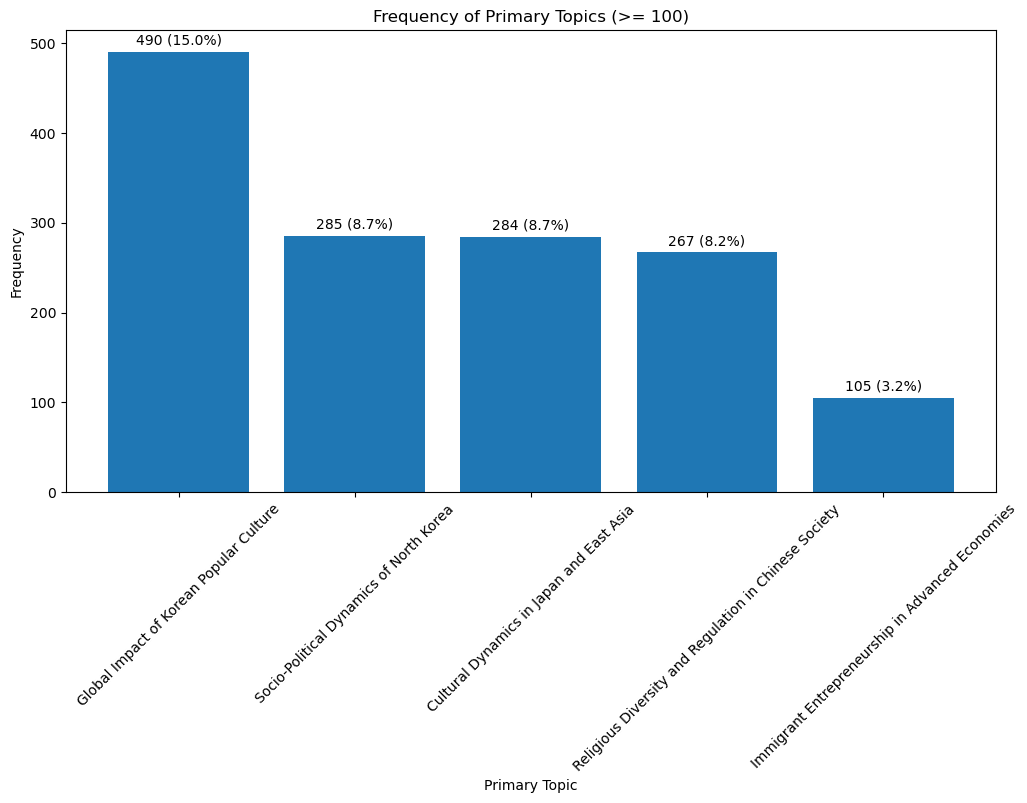

In [171]:
import matplotlib.pyplot as plt

# 빈도수가 100개 이상인 항목들 선택
df_cited_filtered = df_cited['primary_topic_name'].value_counts().loc[lambda x: x >= 100]

# 전체 빈도수 계산
total = df_cited['primary_topic_name'].count()

# 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(df_cited_filtered.index, df_cited_filtered.values)
plt.xlabel('Primary Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Primary Topics (>= 100)')
plt.xticks(rotation=45)

# 각 막대 위에 빈도수와 비율 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval} ({yval/total:.1%})', ha='center', va='bottom')

plt.show()

In [181]:
df_cited_filtered.index.tolist()[:4]

['Global Impact of Korean Popular Culture',
 'Socio-Political Dynamics of North Korea',
 'Cultural Dynamics in Japan and East Asia',
 'Religious Diversity and Regulation in Chinese Society']

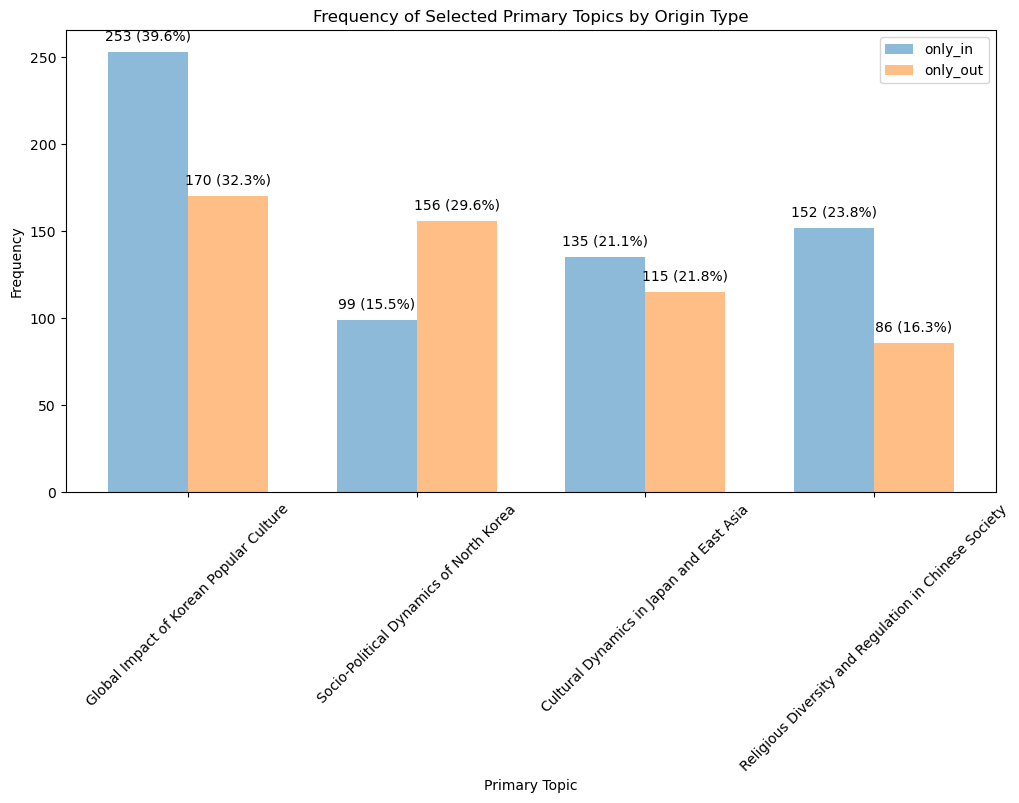

In [182]:
# Define the topics of interest
topics_of_interest = ['Global Impact of Korean Popular Culture', 
                      'Socio-Political Dynamics of North Korea', 
                      'Cultural Dynamics in Japan and East Asia', 
                      'Religious Diversity and Regulation in Chinese Society']

# Filter rows where 'origin_type' is 'only_in' or 'only_out' and 'primary_topic_name' is in topics_of_interest
df_cited_only_in = df_cited[(df_cited['origin_type'] == 'only_in') & df_cited['primary_topic_name'].isin(topics_of_interest)]
df_cited_only_out = df_cited[(df_cited['origin_type'] == 'only_out') & df_cited['primary_topic_name'].isin(topics_of_interest)]

# Calculate frequency for 'primary_topic_name' in each dataframe
df_cited_only_in_freq = df_cited_only_in['primary_topic_name'].value_counts()
df_cited_only_out_freq = df_cited_only_out['primary_topic_name'].value_counts()

# Calculate total counts
total_in = df_cited_only_in['primary_topic_name'].count()
total_out = df_cited_only_out['primary_topic_name'].count()

# Create an array with the position of each bar along the x-axis
x = np.arange(len(topics_of_interest))

# Create plot
plt.figure(figsize=(12, 6))

# Plot 'only_in' bars
bars_in = plt.bar(x - width/2, df_cited_only_in_freq[topics_of_interest].values, width, alpha=0.5, label='only_in')

# Plot 'only_out' bars
bars_out = plt.bar(x + width/2, df_cited_only_out_freq[topics_of_interest].values, width, alpha=0.5, label='only_out')

plt.xlabel('Primary Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Primary Topics by Origin Type')
plt.xticks(x, topics_of_interest, rotation=45)
plt.legend()

# Display frequency and percentage on 'only_in' bars
for i, bar in enumerate(bars_in):
    yval = bar.get_height()
    plt.text(i - width/2, yval + 5, f'{yval} ({yval/total_in:.1%})', ha='center', va='bottom')

# Display frequency and percentage on 'only_out' bars
for i, bar in enumerate(bars_out):
    yval = bar.get_height()
    plt.text(i + width/2, yval + 5, f'{yval} ({yval/total_out:.1%})', ha='center', va='bottom')

plt.show()

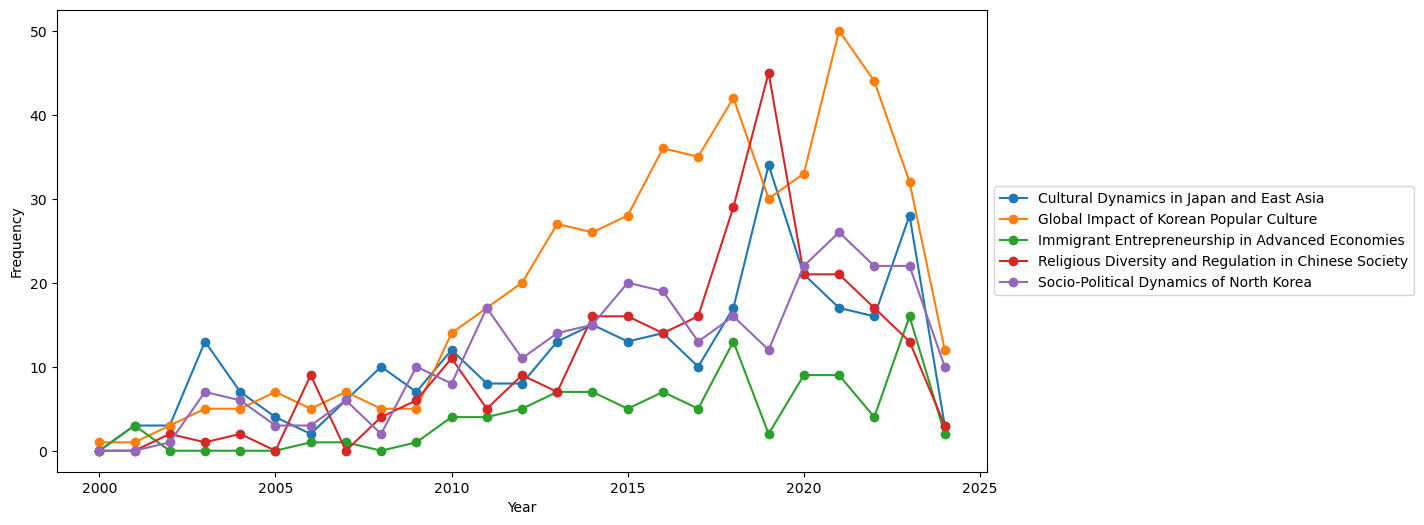

In [156]:
import matplotlib.pyplot as plt

# 빈도수가 100개 이상인 primary_topic_name 추출
top_topics = df_cited['primary_topic_name'].value_counts()
top_topics = top_topics[top_topics >= 100].index

# 연도별 빈도수 계산
topic_counts = df_cited[df_cited['primary_topic_name'].isin(top_topics)].groupby(['publication_year', 'primary_topic_name']).size().unstack()
topic_counts = topic_counts.fillna(0)
# 그래프 시각화
topic_counts.plot(kind='line', marker='o', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Frequency')
# plt.title('Frequency Trend of Top Topics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Move legend outside of the plot
plt.show()

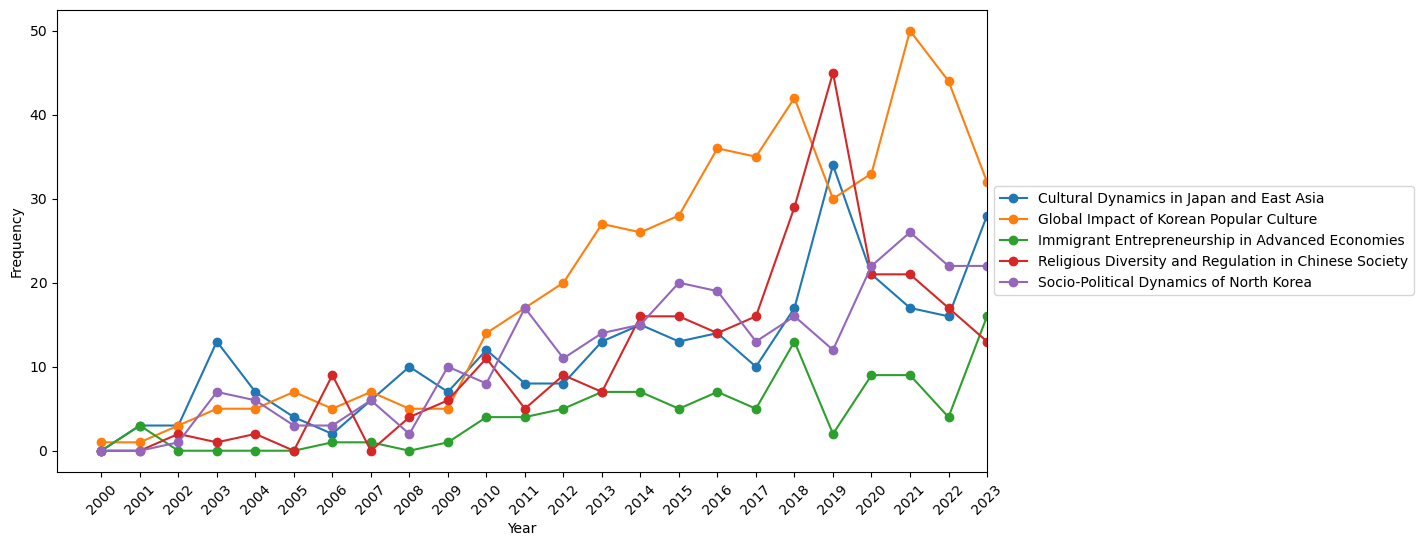

In [207]:
import matplotlib.pyplot as plt

# 빈도수가 100개 이상인 primary_topic_name 추출
top_topics = df_cited['primary_topic_name'].value_counts()
top_topics = top_topics[top_topics >= 100].index

# 연도별 빈도수 계산
topic_counts = df_cited[df_cited['primary_topic_name'].isin(top_topics) & (df_cited['publication_year'] != 2024)].groupby(['publication_year', 'primary_topic_name']).size().unstack()
topic_counts = topic_counts.fillna(0)

# 그래프 시각화
topic_counts.plot(kind='line', marker='o', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xlim(right=2023)  # Set the upper limit of the x-axis to 2023

# Set xticks to 1-year intervals
plt.xticks(np.arange(min(topic_counts.index), 2023+1, 1.0), rotation=45)

# plt.title('Frequency Trend of Top Topics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Move legend outside of the plot
plt.show()

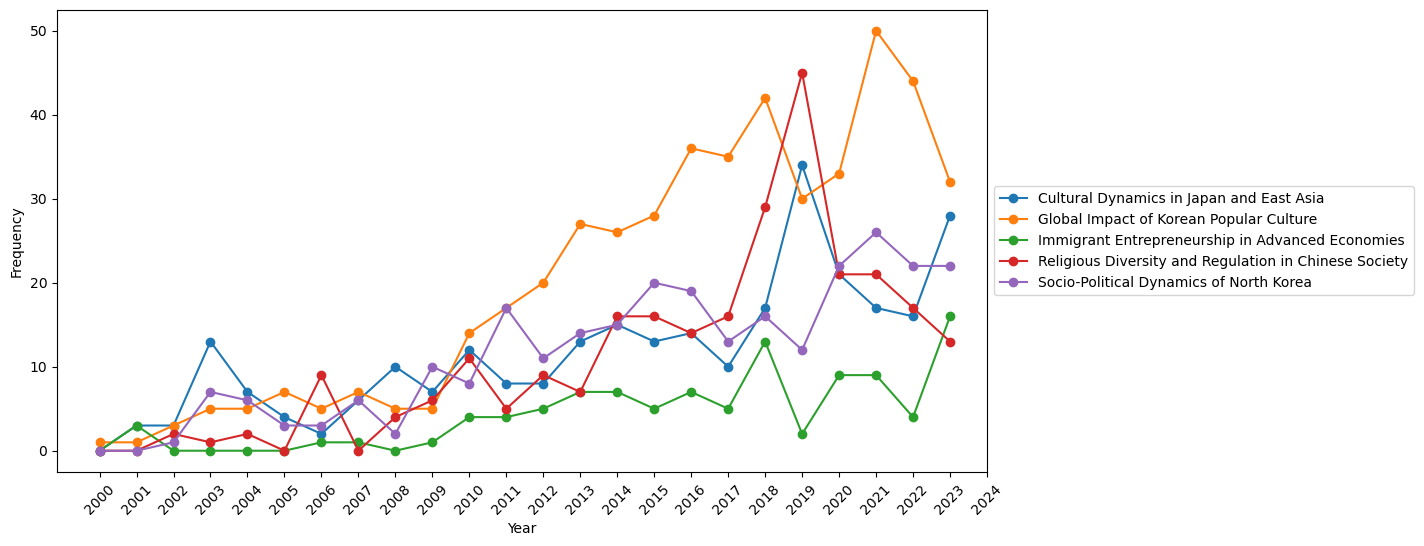

In [208]:
import matplotlib.pyplot as plt

# 빈도수가 100개 이상인 primary_topic_name 추출
top_topics = df_cited['primary_topic_name'].value_counts()
top_topics = top_topics[top_topics >= 100].index

# 연도별 빈도수 계산
topic_counts = df_cited[df_cited['primary_topic_name'].isin(top_topics) & (df_cited['publication_year'] != 2024)].groupby(['publication_year', 'primary_topic_name']).size().unstack()
topic_counts = topic_counts.fillna(0)

# 그래프 시각화
topic_counts.plot(kind='line', marker='o', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xlim(right=2024)  # Set the upper limit of the x-axis to 2024 to avoid cutting off the 2023 data

# Set xticks to 1-year intervals
plt.xticks(np.arange(min(topic_counts.index), 2024+1, 1.0), rotation=45)

# plt.title('Frequency Trend of Top Topics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Move legend outside of the plot
plt.show()

##### 저자

In [183]:
df_cited['authorships_id'] = df_cited.loc[~pd.isna(df_cited['authorships']),'authorships'].progress_map(lambda x:[a['author']['id'] for a in x])

  0%|          | 0/3344 [00:00<?, ?it/s]

In [ ]:
# author_file_names = ['https://openalex.org/'+os.path.splitext(os.path.basename(file))[0] for file in author_file_list]

In [56]:
# # df_cited['authorships_id']를 리스트로 변환
# authorships_id_list = df_cited['authorships_id'].explode().tolist()

# # df_cited['authorships_id']에만 있는 'id' 찾기
# # unique_ids = [id for id in authorships_id_list if id not in author_file_names]
# unique_ids = [id.split('/')[-1] for id in authorships_id_list if id not in author_file_names and not (isinstance(id, (int, float)) and math.isnan(id))]

In [57]:
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.0.0 Safari/537.36",
#     "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
#     "Accept-Language": "en-US,en;q=0.9",
#     "Accept-Encoding": "gzip, deflate, br",
#     "Connection": "keep-alive",
#     "DNT": "1", # Do Not Track 요청 헤더 (사용자 추적 거부)
#     # 필요한 추가 헤더를 여기에 추가
# }

In [58]:
# def request_until_success(url, headers, timeout=25, delay=5):
#     """
#     Continuously makes a request to the specified URL with a timeout until the request is successful.

#     Args:
#     - url (str): The URL to request.
#     - timeout (int): The timeout for the request in seconds.
#     - delay (int): The delay between retries in seconds.

#     Returns:
#     - response: The successful response from the server.
#     """
#     attempt = 1
#     while True:
#         try:
#             # print(f"Attempt {attempt}")
#             response = requests.get(url,headers=headers, timeout=timeout)
#             response.raise_for_status()  # Raises HTTPError for bad responses
#             # print("Request successful")
#             return response.json()
#         except requests.Timeout as e:
#             print(f"Request timed out: {e}")
#         except requests.RequestException as e:
#             print(f"Request failed: {e}")
        
#         # print(f"Retrying in {delay} seconds...")
#         time.sleep(delay)
#         attempt += 1

In [59]:
# author_cited_file_list = glob.glob('./data/author_cited/*.json')
# author_cited_file_list = [os.path.splitext(os.path.basename(file))[0] for file in author_cited_file_list]

In [63]:
# unique_ids_no_duplicates = [id for id in unique_ids if id not in author_cited_file_list]
# unique_ids_no_duplicates = list(set(unique_ids_no_duplicates))

In [66]:
# unique_ids_no_duplicates.remove('A9999999999')

In [ ]:
# def fetch_and_save_author_info(id):
#     id = id.split('/')[-1]
#     url = f'https://api.openalex.org/authors/{id}&mailto=kuntakim88@gmail.com'
#     page_with_results = request_until_success(url,headers)
#     # json으로 저장
#     with open(f'./data/author_cited/{id}.json','w') as f:
#         json.dump(page_with_results,f)

# # 저자정보 추가수집
# with ThreadPoolExecutor(max_workers=2) as executor:
#     list(tqdm(executor.map(fetch_and_save_author_info, unique_ids_no_duplicates), total=len(unique_ids_no_duplicates)))

In [184]:
df_cited['country_code'] = df_cited['authorships_id'].dropna().apply(get_country_codes)
df_cited['country_code'] = df_cited['country_code'].dropna().apply(lambda lst: [x for x in lst if x is not None])

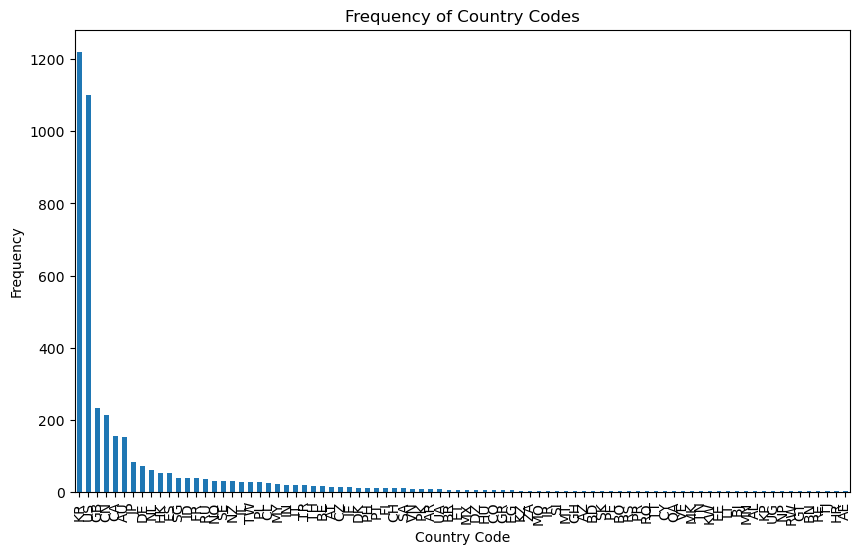

In [188]:
import matplotlib.pyplot as plt

# 리스트 열을 풀어서 개별 행으로 만들기
exploded_df = df_cited.explode('country_code')

# 국가 코드의 빈도수 계산
country_counts = exploded_df['country_code'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.title('Frequency of Country Codes')
plt.show()

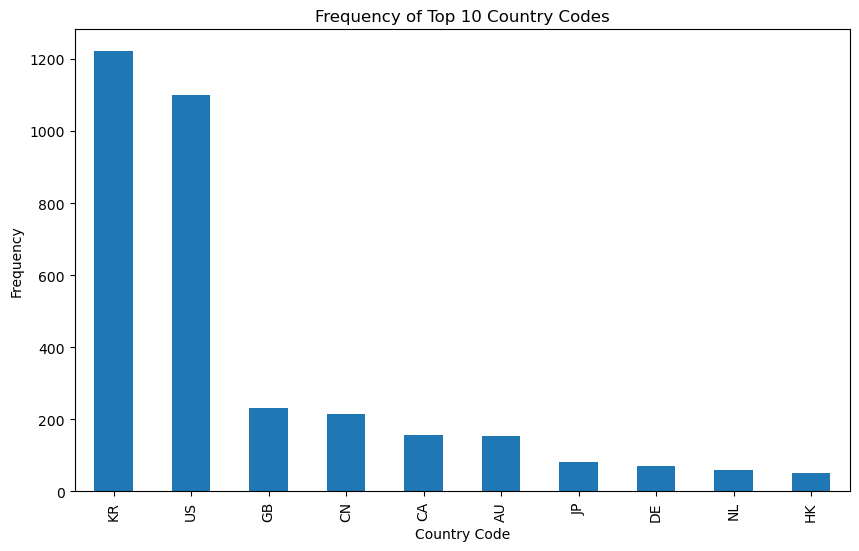

In [189]:
import matplotlib.pyplot as plt

# 리스트 열을 풀어서 개별 행으로 만들기
exploded_df = df_cited.explode('country_code')

# 국가 코드의 빈도수 계산
country_counts = exploded_df['country_code'].value_counts()

# 상위 10개 국가 코드 선택
top_10_country_counts = country_counts.head(10)

# 시각화
plt.figure(figsize=(10, 6))
top_10_country_counts.plot(kind='bar')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Country Codes')
plt.show()

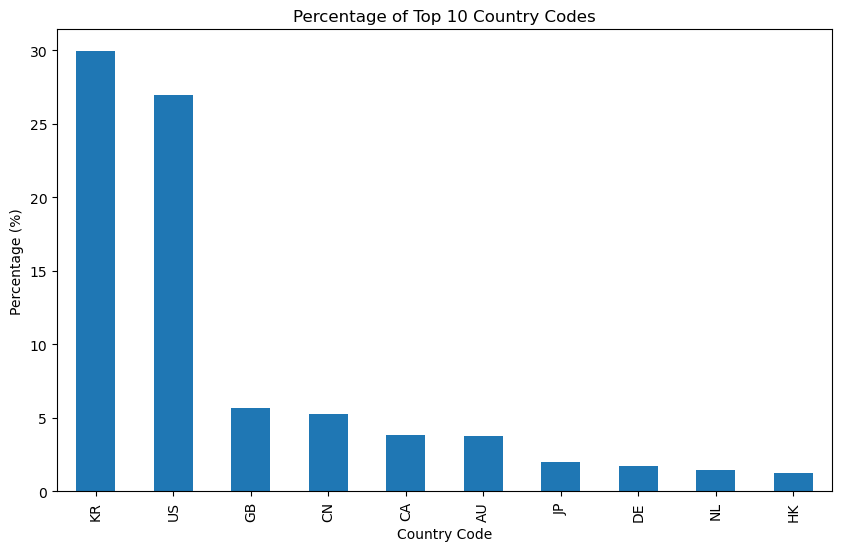

In [209]:
import matplotlib.pyplot as plt

# 리스트 열을 풀어서 개별 행으로 만들기
exploded_df = df_cited.explode('country_code')

# 국가 코드의 빈도수 계산
country_counts = exploded_df['country_code'].value_counts()

# 상위 10개 국가 코드 선택
top_10_country_counts = country_counts.head(10)

# Convert frequencies to percentages
top_10_country_counts = top_10_country_counts / country_counts.sum() * 100

# 시각화
plt.figure(figsize=(10, 6))
top_10_country_counts.plot(kind='bar')
plt.xlabel('Country Code')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Top 10 Country Codes')
plt.show()

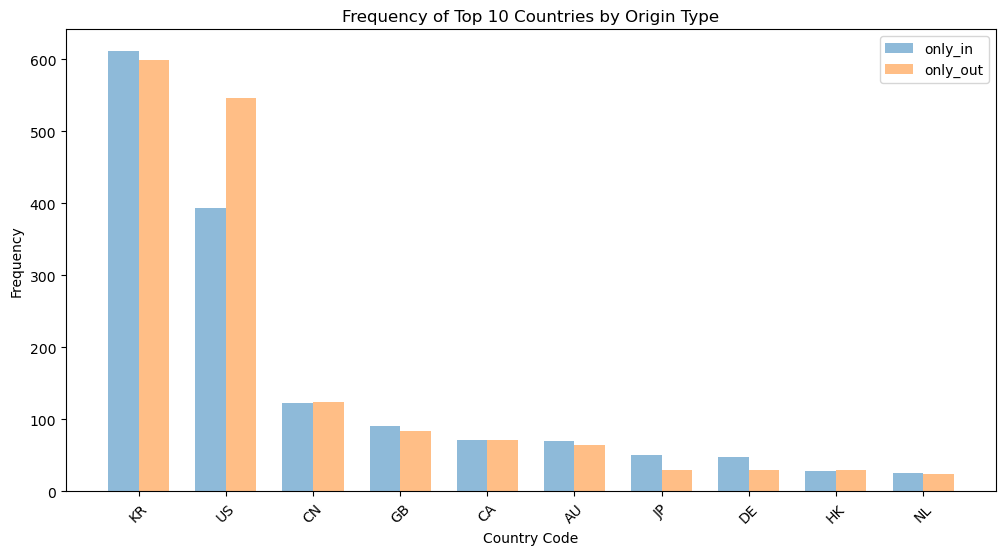

In [191]:
# Explode 'country_code'
df_cited_exploded = df_cited.explode('country_code')

# Filter rows where 'origin_type' is 'only_in' or 'only_out'
df_cited_exploded_only_in = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_in']
df_cited_exploded_only_out = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_out']

# Calculate frequency for 'country_code' in each dataframe and select top 10
df_cited_exploded_only_in_freq = df_cited_exploded_only_in['country_code'].value_counts().nlargest(10)
df_cited_exploded_only_out_freq = df_cited_exploded_only_out['country_code'].value_counts().nlargest(10)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(df_cited_exploded_only_in_freq.index))

# Define the width of the bars
width = 0.35

# Create plot
plt.figure(figsize=(12, 6))

# Plot 'only_in' bars
bars_in = plt.bar(x - width/2, df_cited_exploded_only_in_freq.values, width, alpha=0.5, label='only_in')

# Plot 'only_out' bars
bars_out = plt.bar(x + width/2, df_cited_exploded_only_out_freq.values, width, alpha=0.5, label='only_out')

plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Countries by Origin Type')
plt.xticks(x, df_cited_exploded_only_in_freq.index, rotation=45)
plt.legend()

plt.show()

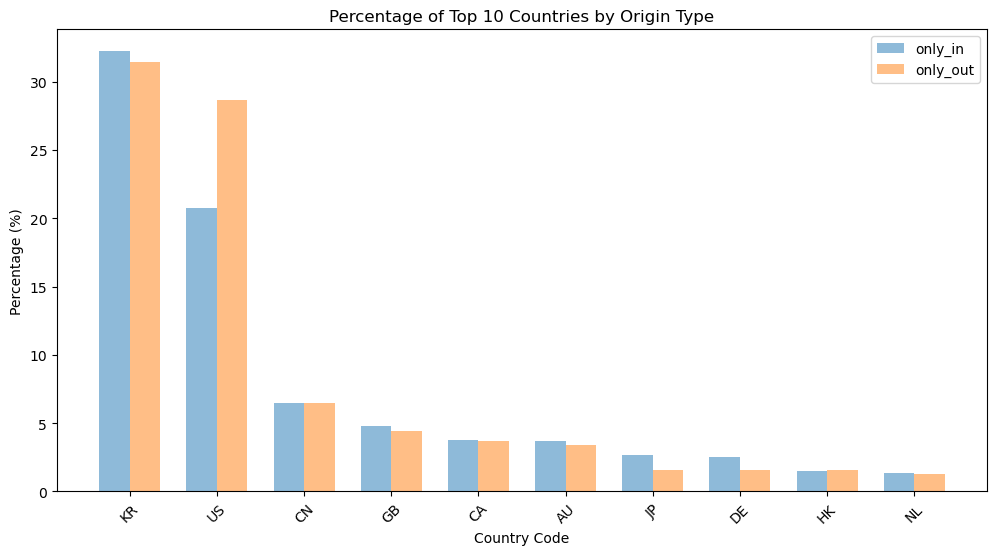

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Explode 'country_code'
df_cited_exploded = df_cited.explode('country_code')

# Filter rows where 'origin_type' is 'only_in' or 'only_out'
df_cited_exploded_only_in = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_in']
df_cited_exploded_only_out = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_out']

# Calculate frequency for 'country_code' in each dataframe and select top 10
df_cited_exploded_only_in_freq = df_cited_exploded_only_in['country_code'].value_counts().nlargest(10)
df_cited_exploded_only_out_freq = df_cited_exploded_only_out['country_code'].value_counts().nlargest(10)

# Convert frequencies to percentages
df_cited_exploded_only_in_freq = df_cited_exploded_only_in_freq / df_cited_exploded_only_in['country_code'].count() * 100
df_cited_exploded_only_out_freq = df_cited_exploded_only_out_freq / df_cited_exploded_only_out['country_code'].count() * 100

# Create an array with the position of each bar along the x-axis
x = np.arange(len(df_cited_exploded_only_in_freq.index))

# Define the width of the bars
width = 0.35

# Create plot
plt.figure(figsize=(12, 6))

# Plot 'only_in' bars
bars_in = plt.bar(x - width/2, df_cited_exploded_only_in_freq.values, width, alpha=0.5, label='only_in')

# Plot 'only_out' bars
bars_out = plt.bar(x + width/2, df_cited_exploded_only_out_freq.values, width, alpha=0.5, label='only_out')

plt.xlabel('Country Code')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Top 10 Countries by Origin Type')
plt.xticks(x, df_cited_exploded_only_in_freq.index, rotation=45)
plt.legend()

plt.show()

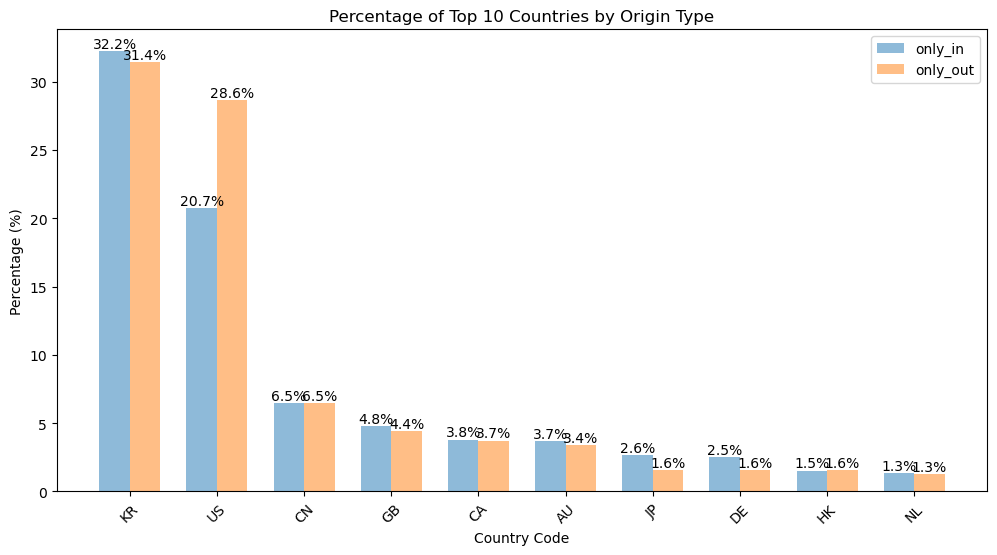

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Explode 'country_code'
df_cited_exploded = df_cited.explode('country_code')

# Filter rows where 'origin_type' is 'only_in' or 'only_out'
df_cited_exploded_only_in = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_in']
df_cited_exploded_only_out = df_cited_exploded[df_cited_exploded['origin_type'] == 'only_out']

# Calculate frequency for 'country_code' in each dataframe and select top 10
df_cited_exploded_only_in_freq = df_cited_exploded_only_in['country_code'].value_counts().nlargest(10)
df_cited_exploded_only_out_freq = df_cited_exploded_only_out['country_code'].value_counts().nlargest(10)

# Convert frequencies to percentages
df_cited_exploded_only_in_freq = df_cited_exploded_only_in_freq / df_cited_exploded_only_in['country_code'].count() * 100
df_cited_exploded_only_out_freq = df_cited_exploded_only_out_freq / df_cited_exploded_only_out['country_code'].count() * 100

# Create an array with the position of each bar along the x-axis
x = np.arange(len(df_cited_exploded_only_in_freq.index))

# Define the width of the bars
width = 0.35

# Create plot
plt.figure(figsize=(12, 6))

# Plot 'only_in' bars
bars_in = plt.bar(x - width/2, df_cited_exploded_only_in_freq.values, width, alpha=0.5, label='only_in')

# Plot 'only_out' bars
bars_out = plt.bar(x + width/2, df_cited_exploded_only_out_freq.values, width, alpha=0.5, label='only_out')

# Add text on the top of each bar
for i in range(len(x)):
    plt.text(x[i] - width/2, df_cited_exploded_only_in_freq.values[i], f'{df_cited_exploded_only_in_freq.values[i]:.1f}%', ha = 'center', va = 'bottom')
    plt.text(x[i] + width/2, df_cited_exploded_only_out_freq.values[i], f'{df_cited_exploded_only_out_freq.values[i]:.1f}%', ha = 'center', va = 'bottom')

plt.xlabel('Country Code')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Top 10 Countries by Origin Type')
plt.xticks(x, df_cited_exploded_only_in_freq.index, rotation=45)
plt.legend()

plt.show()